In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn import metrics
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

In [2]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("adult.csv", header=None, names = heading, na_values="?", skipinitialspace = True)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df['target'] = df['income']
df['target'] = np.where(df['income'].isin(['>50K']), 1, 0)

In [4]:
df = df.drop(['fnlwgt'], axis=1)

In [5]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [6]:
df.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
target               0
dtype: int64

In [7]:
df['workclass'].fillna('Other', inplace = True)
df['occupation'].fillna('Other', inplace = True)
df['native-country'].fillna('Other', inplace = True)

In [8]:
pd.isnull(df["workclass"]).value_counts()

False    32561
Name: workclass, dtype: int64

In [9]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features = df.columns.tolist()
features.remove(target)
X = df[features]
y = df[target]

In [10]:
def GridSearch(param, estimator, X=X, y=y):
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    grid_rf = GridSearchCV(estimator, param, refit = True, verbose = 3, n_jobs=-1) 

    # fitting the model for grid search 
    grid_rf.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid_rf.best_params_) 
    grid_rf_predictions = grid_rf.predict(X_test) 

    # print classification report 
    return classification_report(y_test, grid_rf_predictions)

In [11]:
 def ConfusionMatrix(classifier, X=X, y=y):
        #computing the confusion matrix with each row corresponding to the true class
        conf_matrix = confusion_matrix(y_test, y_pred)
        f,ax = plt.subplots(figsize=(7,7))
        sns.heatmap(conf_matrix,annot=True,linewidths=0.5,linecolor="white",fmt=".0f",ax=ax)
        plt.xlabel("y_test")
        plt.ylabel("predict")
        plt.show()

#         #drawing Plot Confusion Matrix
#         if(plotConfusionMatrix):
#             conf_matrix =confusion_matrix(y_test, y_pred)
#             f,ax = plt.subplots(figsize=(7,7))
#             sns.heatmap(conf_matrix,annot=True,linewidths=0.5,linecolor="white",fmt=".0f",ax=ax)
#             plt.xlabel("y_test")
#             plt.ylabel("predict")
#             plt.show()

In [12]:
def featuresToOther(column, dataframe = df, percent=0.05, name_for_other="Other"):
    
    '''This function change features under given threshold to one group. 
    The group is called by name_for_other, default- Other'''
    
    frame = dataframe[column].value_counts().to_frame()
    values =  dataframe[column].value_counts().index.tolist()
    sum_of_count = 0
    for n in range(len(frame.index)): 
        sum_of_count += frame.iloc[n]
    threshold = sum_of_count.iloc[0]*percent
    list_values_to_change= []
    for i in range(len(frame.index)):
        num = frame.iloc[i, 0]
        if(num < threshold):
            list_values_to_change.append(values[i])
    dataframe[column].replace(list_values_to_change, name_for_other, inplace = True)

In [13]:
insignificant_values = ['workclass', 'occupation', 'race', 'native-country']
for value in insignificant_values:
    featuresToOther(column=value, dataframe=df, percent=0.04)

In [14]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features = df.columns.tolist()
features.remove(target)
X = df[features]
y = df[target]

In [15]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('onehot', SklearnOneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

model score: 0.822


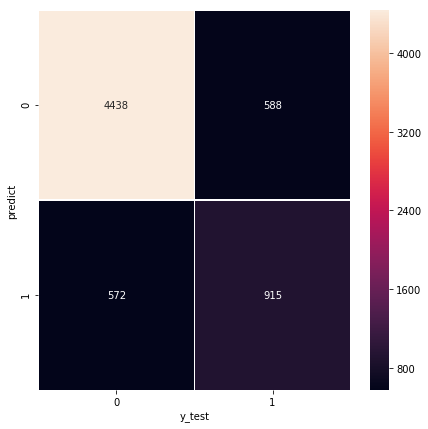

In [16]:
#a. Desicion Tree Classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  DecisionTreeClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("model score: %.3f" % clf.score(X_test, y_test))

ConfusionMatrix(classifier=clf)

In [17]:
print('     Classifiction report of Decision Tree model')
print('------------------------------------------------------')
print(classification_report(y_test,y_pred))

     Classifiction report of Decision Tree model
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5026
           1       0.61      0.62      0.61      1487

   micro avg       0.82      0.82      0.82      6513
   macro avg       0.75      0.75      0.75      6513
weighted avg       0.82      0.82      0.82      6513



In [18]:
#Misclassification rate
conf = confusion_matrix(y_test,y_pred)
FP = conf.sum(axis=0) - np.diag(conf)  
FN = conf.sum(axis=1) - np.diag(conf)
misclassificationRate = (FP+FN)/6513
print('Misclassification rate of Decision Tree: %.2f' % misclassificationRate[0])

Misclassification rate of Decision Tree: 0.18


model score: 0.862


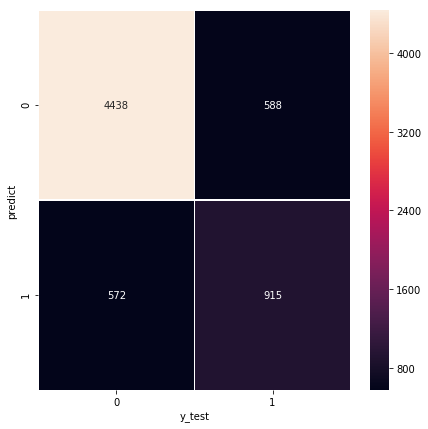

In [19]:
#b. Random Forest Classifier
import warnings

warnings.filterwarnings("ignore")
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  RandomForestClassifier())])
param = {'classifier__max_depth': [20, 50],
         'classifier__max_features': [10, 30],
         'classifier__min_samples_split': [10, 30]}
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
print("model score: %.3f" % gs.score(X_test, y_test))
ConfusionMatrix(classifier=gs)

In [20]:
print('     Classifiction report of Random Forest model')
print('------------------------------------------------------')
print(classification_report(y_test,y_pred))

     Classifiction report of Random Forest model
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5026
           1       0.61      0.62      0.61      1487

   micro avg       0.82      0.82      0.82      6513
   macro avg       0.75      0.75      0.75      6513
weighted avg       0.82      0.82      0.82      6513



In [21]:
#Misclassification rate
conf = confusion_matrix(y_test,y_pred)
FP = conf.sum(axis=0) - np.diag(conf)  
FN = conf.sum(axis=1) - np.diag(conf)
misclassificationRate = (FP+FN)/6513
print('Misclassification rate of Random Forest model: %.2f' % misclassificationRate[0])

Misclassification rate of Random Forest model: 0.18


model score: 0.845


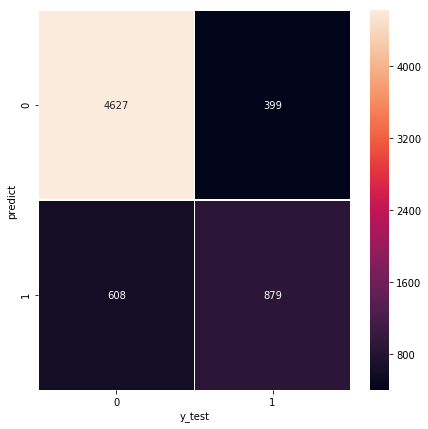

In [22]:
#c. Logistic Regression
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  LogisticRegression())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("model score: %.3f" % clf.score(X_test, y_test))
ConfusionMatrix(classifier=clf)

In [23]:
print('    Classifiction report of Logistic regression')
print('------------------------------------------------------')
print(classification_report(y_test,y_pred))

    Classifiction report of Logistic regression
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5026
           1       0.69      0.59      0.64      1487

   micro avg       0.85      0.85      0.85      6513
   macro avg       0.79      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



In [24]:
#Misclassification rate
conf = confusion_matrix(y_test,y_pred)
FP = conf.sum(axis=0) - np.diag(conf)  
FN = conf.sum(axis=1) - np.diag(conf)
misclassificationRate = (FP+FN)/6513
print('Misclassification rate of Logistic Regression: %.2f' % misclassificationRate[0])

Misclassification rate of Logistic Regression: 0.15


model score: 0.841


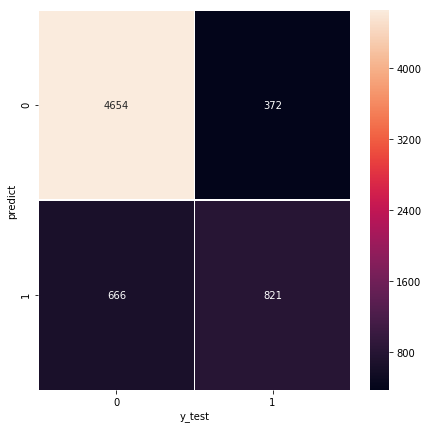

In [25]:
#d. KNN Classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn',  KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform'))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("model score: %.3f" % clf.score(X_test, y_test))
ConfusionMatrix(classifier=clf)

In [26]:
print('      Classifiction report of KNN algorithm model')
print('------------------------------------------------------')
print(classification_report(y_test,y_pred))

      Classifiction report of KNN algorithm model
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5026
           1       0.69      0.55      0.61      1487

   micro avg       0.84      0.84      0.84      6513
   macro avg       0.78      0.74      0.76      6513
weighted avg       0.83      0.84      0.83      6513



In [27]:
#Misclassification rate
conf = confusion_matrix(y_test,y_pred)
FP = conf.sum(axis=0) - np.diag(conf)  
FN = conf.sum(axis=1) - np.diag(conf)
misclassificationRate = (FP+FN)/6513
print('Misclassification rate of KNN: %.2f' % misclassificationRate[0])

Misclassification rate of KNN: 0.16


model score: 0.849


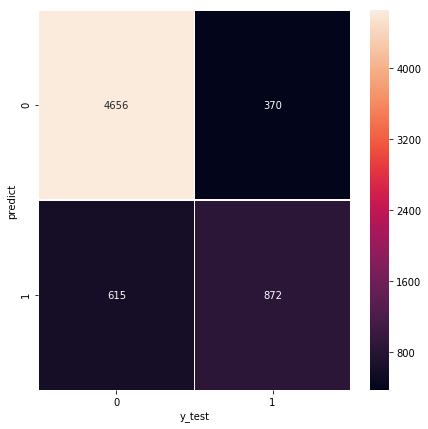

In [28]:
#e. svc classifier with linear classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('svc',  SVC(C = 1, kernel = "linear", gamma = "scale"))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("model score: %.3f" % clf.score(X_test, y_test))
ConfusionMatrix(classifier=clf)

In [29]:
print('     Classifiction report of SVC Classifier model')
print('------------------------------------------------------')
print(classification_report(y_test,y_pred))

     Classifiction report of SVC Classifier model
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5026
           1       0.70      0.59      0.64      1487

   micro avg       0.85      0.85      0.85      6513
   macro avg       0.79      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



In [30]:
#Misclassification rate
conf = confusion_matrix(y_test,y_pred)
FP = conf.sum(axis=0) - np.diag(conf)  
FN = conf.sum(axis=1) - np.diag(conf)
misclassificationRate = (FP+FN)/6513
print('Misclassification rate of SVC classifier model: %.2f' % misclassificationRate[0])

Misclassification rate of SVC classifier model: 0.15
